In [1]:
%matplotlib inline
from numpy import *
from matplotlib.pyplot import *
import sympy as sym
import pandas as pd

In [2]:
def finDif(omega,f,n,bc):
    x = linspace(min(omega), max(omega), n)
    h = (max(omega)-min(omega))/(n-1)
    
    #creating A:
    diagonal = 30*ones((n,))  
    off_diag_1 = -16*ones((n-1,))
    off_diag_2 = ones((n-2,))
    
    A = (diag(off_diag_2, -2) + diag(off_diag_1, -1) + diag(diagonal, 0) + diag(off_diag_1, +1) + diag(off_diag_2, +2)) 
    
    A /= 12*h**2
    
    #imposing boundary conditions:
    A[0,:], A[:,0], A[-1,:], A[:,-1] = bc[0], bc[0], bc[1], bc[1]
    A[0,0], A[-1,-1] = 1, 1
    b = f(x)    
    b[0], b[-1] = bc[0], bc[1]
        
    return A, b

In [5]:
omega = [0,pi]
f = lambda x : sin(x)
n=100
bc = [0,0]
A, b = finDif(omega, f, n, bc)

In [ ]:
Implement two functions that compute the LU and the Cholesky factorization of the system matrix $A$

In [7]:
def LU(A):
    A = A.copy()
    N=len(A)
    for k in range(N-1):
        if (abs(A[k,k]) < 1e-15):
            raise RuntimeError("Null pivot")
            
        A[k+1:N,k] /= A[k,k]
        for j in range(k+1,N):
            A[k+1:N,j] -= A[k+1:N,k]*A[k,j]
    
    L=tril(A)
    for i in range(N):
        L[i,i]=1.0
    U = triu(A)
    return L, U

L, U = LU(A)

In [8]:
def cholesky(A):
    A = A.copy()
    N = len(A)
    for k in range(N-1):
        A[k,k] = sqrt(A[k,k])
        A[k+1:N,k] = A[k+1:N,k]/A[k,k]
        
        for j in range(k+1,N):
            A[j:N,j] = A[j:N,j] - A[j:N,k]*A[j,k]
        
    A[-1,-1] = sqrt(A[-1,-1])
    R=tril(A)
    return R.transpose(), R

HT, H = cholesky(A)

In [ ]:
Implement forward and backward substitution functions to exploit the developed factorization methods to solve the derived linear system of equations.

In [9]:
def L_solve(L,rhs):
    x = zeros_like(rhs)
    N = len(L)   
    x[0] = rhs[0]/L[0,0]
    for i in range(1,N):
        x[i] = (rhs[i] - dot(L[i, 0:i], x[0:i]))/L[i,i]
    
    return x

In [10]:
def U_solve(U,rhs):
    x = zeros_like(rhs)
    N = len(U)
    
    x[-1] = rhs[-1]/L[-1,-1]
    for k in range(1,N):
        x[-k] = (rhs[-k] - dot(U[-k, -k:], x[-k:]))/U[-k,-k]
    
    return x

In [ ]:
Solve the derived linear system using the implemented functions and plot the computed solution:

Text(0.5, 1.0, 'Numerical solution')

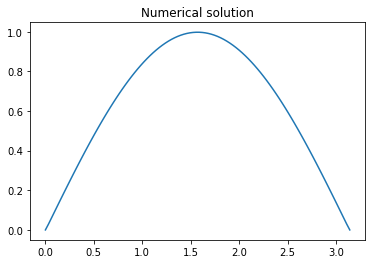

In [11]:
#Au=b iff Lx = b and Uu = x
L, U = LU(A)

y = L_solve(L, b)
u_hat = U_solve(U, y)

x = linspace(0,pi, n)

plot(x, u_hat)
title('Numerical solution')


In [ ]:
Considering the new domain $\Omega = (0,1)$ and the forcing term $f(x) = x(1-x)$ with B.C. $u(x) = 0$, on $\partial \Omega = {0,1}$ produce a plot and a table where you show the decay of the error w.r.t. the number of grid points.
(The analytical solution for the above problems is $u_{an} = \frac{x^4}{12} - \frac{x^3}{6} + \frac{x}{12}$)

In [12]:
omega = [0,1]
n = 100
f = lambda x: x*(1-x)
bc = [0,0]
analytical_solution = lambda x: x**4/12-x**3/6+x/12

,N,error
0,10,0.001936
1,20,0.001419
2,30,0.001167
3,40,0.001013
4,50,0.000908
5,60,0.000829
6,70,0.000768
7,80,0.000719
8,90,0.000678
9,100,0.000643


Text(0, 0.5, 'error')

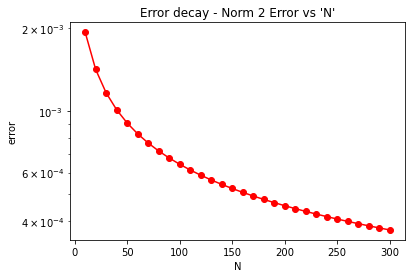

In [13]:
gridpoints_range = arange(10,301,10)

error_approx_norm=zeros(len(gridpoints_range))

for i,n_val in enumerate(gridpoints_range):
    x = linspace(0,1,n_val)
    A_new, b_new = finDif(omega, f, n_val, bc)
    L_new, U_new = LU(A_new)
    y_new = L_solve(L_new, b_new)
    u_numerical = U_solve(U_new, y_new)
    u_analytical = analytical_solution(x)
    error_approx_norm[i] = linalg.norm(u_analytical - u_numerical, 2)
    

#showing the table of errors
Table_errors = pd.DataFrame({'N' : gridpoints_range, 'error' : error_approx_norm})  
display(Table_errors)

#plotting the decay of the error in norm 2 w.r.t. the number of grid points
_ = semilogy(gridpoints_range, error_approx_norm, 'o-',color='red')
title("Error decay - Norm 2 Error vs 'N'")
xlabel('N')
ylabel('error')

In [ ]:
Exploit the derived LU factorizations to compute the condition number of the system's matrix $A$ using the original problem formulation.

In [14]:
#as A is symmetric positive defined, we can compute the ratio of the maximal eigenvalues against the minimal one

#power method to find lambda_max
def PM(A,z0,tol,nmax):
    
    q = z0/linalg.norm(z0,2)
    it = 0
    err = tol + 1.
    while it < nmax and err > tol:
        z = dot(A,q)
        l = dot(q.T,z)
        err = linalg.norm(z-l*q,2)
        q = z/linalg.norm(z,2)        
        it += 1
    return l

#inverse power method to find lambda_min
def IPM(A, x0, mu, tol, nmax ):
    M = A - mu * identity(len(A))
    L,U = LU(M)
    err = tol + 1.
    it = 0
    q = x0/(linalg.norm(x0,2))
    while it < nmax and err > tol :
        y = L_solve(L,q)
        x = U_solve(U,y)
        q = x/(linalg.norm(x,2))
        z = dot(A,q)
        l = dot(q.T,z)
        err = linalg.norm(z-l*q,2)
        it += 1
    return l, q

def condNumb(A, eps, tol, nmax):
    n = shape(A)[0]
    z0 = random.rand(n)
    l_min, _ = IPM(A, z0, eps, tol, nmax)
    l_max = PM( A, z0, tol, nmax)
    condNu = l_max/l_min
    return condNu

In [15]:
print(condNumb(A, 1e-10, 1e-12, 1000))


5276.154174055284


In [ ]:
Implement a preconditioned Conjugant Gradient method to solve the original linear system of equations using an iterative method:

In [16]:
def conjugate_gradient(A, b, P, eps):
    u = ones_like(b)
    tollerance = eps+1
    residuals = b - dot(A,u)
    z = linalg.solve(P,residuals)
    p = z
    k = 0
    while (k < len(A) and tollerance > eps):
        alpha = dot(p, residuals)/dot(p,dot(A,p))
        u += alpha*p
        residuals += -alpha*dot(A,p)
        z = linalg.solve(P,residuals)
        beta = dot(dot(A,p),z)/dot(dot(A,p),p)
        p = z - beta*p
        tollerance = linalg.norm(residuals,2)
        k += 1
    return u  

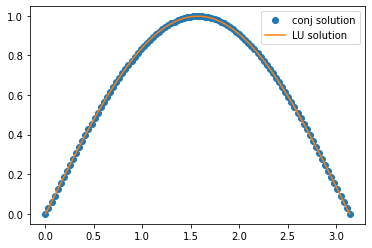

In [17]:
x = linspace(0,pi, len(A))
u_conj = conjugate_gradient(A, b, diag(diag(A)),1e-12 )
_ = plot(x, u_conj,'o' ,label = 'conj solution')
_ = plot(x, u_hat, label = 'LU solution')
legend()

In [ ]:
Consider the following time dependent variation of the PDE starting from the orginal problem formulation:
$$
u'(t)-u_{xx} = \alpha(t)f(x)
$$

for $t\in [0,T]$, with $\alpha(t) = \cos(t)$ and $T = 6\pi$

Use the same finite difference scheme to derive the semi-discrete formulation and solve it using a forward Euler's method.

Plot the time dependent solution solution at $x = \pi/2$, $x=1$, 
$x=\pi$


In [ ]:
Given that we can approximate $u_{xx}$ as $A\hat{u}_{xx}$, the problem can be written as: 
$$u'(t)=\alpha(t)f(x)+A\hat{u}_{xx}$$
From which we derive the discretization to use for Forward Euler Method: 
$$\frac{u(t_n)-u(t_{n-1})}{h}=\alpha(t_{n-1})f(x)+A\hat{u}_{xx}\Rightarrow u(t_n)=u(t_{n-1})+h\alpha(t_{n-1})f(x)+hA\hat{u}_{xx}$$

In [22]:
def ForwardEulerPDE(omega, I, f, alpha, u0, n, bc, h):
    timesteps = arange(I[0],I[-1]+1e-10, h)      
    numerical_solution = zeros((len(timesteps), len(u0))) #create a matrix where rows are solutions at a given time step  
    numerical_solution[0] = u0 #initial condition
    A, b = finDif(omega,f,n,bc)
    for k in range(1,len(timesteps)):
        Au_xx = -dot(A,numerical_solution[k-1])     
        alpha_f = alpha(timesteps[k-1])*b        
        numerical_solution[k] = numerical_solution[k-1] + h*Au_xx + h*alpha_f
    return numerical_solution, timesteps

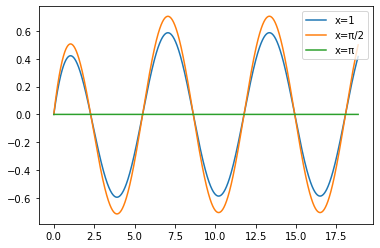

In [23]:
omega = [0,pi]
I = [0, 6*pi]
alpha = lambda t: cos(t)
f = lambda x : sin(x)
bc = [0,0]
u0 = zeros((n,))

#ensuring stability property to hold
max_eig = PM(A, random.rand(100), 1e-10, 1000)
h = 1/max_eig

u_hat, t = ForwardEulerPDE(omega, I, f, alpha, u0, 100, bc, h)

x_pi_half = round(100 / (omega[-1] - omega[0]) * pi/2.) -1
x_one = round(100/(omega[-1] - omega[0])) - 1
x_pi = round(100/(omega[-1] - omega[0])*pi) - 1

_ = plot(t, u_hat[:,x_one], label='x=1')
_ = plot(t, u_hat[:,x_pi_half], label='x=π/2')
_ = plot(t, u_hat[:,x_pi], label='x=π')
_ = legend(loc='upper right')

In [ ]:
Given the original $Au = b$ system, implement an algorithm to compute the eigenvalues and eigenvectors of the matrix $A$. Exploit the computed LU factorization

In [24]:
def Eigenvalues_LU(A, eps, n_iterations):
    err = eps + 1.0
    A = A.copy()
    eigenvalues_old = diag(A)
    eigenvalues_approx = zeros_like(eigenvalues_old)
    it = 0
    while (err > eps):
        # update matrix
        L, U = LU(A)
        A = U@L
        
        # get error
        eigenvalues_approx = diag(A)
        err = max(abs(eigenvalues_approx-eigenvalues_old))
        
        # update
        eigenvalues_old = eigenvalues_approx
        it += 1
    return sort(eigenvalues_approx)


In [25]:
def Eigenvectors_LU(A, eps, n_iterations):
    eigenvectors = zeros_like(eigenvalues)
    N = len(eigenvalues)
    x0 = ones_like(eigenvalues)
    for k in range(1,N):
        _, eigenvectors = IPM(A, x0, mu, eps, n_iterations)
    return eigenvectors
    

In [ ]:
Compute the inverse of the matrix A exploiting the derived LU factorization

In [26]:
def inverse_matrix(A):
    m = shape(A)[0]
    A_inverse = nones_like(A)
    L,U = LU(A)
    for i in range(m):
        e = zeros((m,))
        e[i] = 1
        y = L_solve(L,e)
        x = U_solve(U,y)
        A_inverse[:,i] = x
    return A_inverse 

In [ ]:
Consider the following Cauchy problem
$$
\begin{cases}
y'= -ty^2 \quad 0\le t \le 2\\
y(0) = 1
\end{cases}
$$
Implement a Backward Euler's method in a suitable function and solve the resulting non-linear equation using a Newton's method.

In [27]:
def Newton(f, f_prime, x0, tol, n_iterations):
    error = abs(f(x0))
    
    it = 0
    x = x0
    
    while (error > tol and it < n_iterations):
        q_k = f_prime(x)
        if abs(q_k) < 1e-12:
            raise RuntimeError('f_prime(x) is too close to 0')
        
        x_updated = x - f(x)/q_k
        error = abs(f(x_updated))
        
        x = x_updated
        it += 1    
    return x


def BackWardEu(y0, t0, tf, h, tol, n_iterations):
    timesteps = arange(t0,tf+1e-10, h)
    
    #initializing the numerical solution
    y_hat = zeros_like(timesteps) 
    y_hat[0] = y0
    N = len(y_hat)
    
    for n in range(1,N):
        F = lambda x: x - y_hat[n-1]+h*timesteps[n]*x**2 
        F_prime = lambda x:  1+2*h*timesteps[n] * x
        y_hat[n] = Newton(F, F_prime, y_hat[n-1], tol, n_iterations) 
    
    return y_hat, timesteps

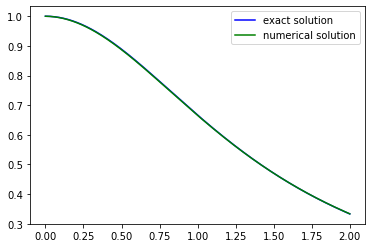

In [28]:
f_exact = lambda x: 2/(x**2+2)
numerical_solution, t = BackWardEu(1, 0, 2, 0.01, 1e-10, 100)

plot(t, f_exact(t),'b' ,label = 'exact solution')
plot(t, numerical_solution, 'g', label = 'numerical solution')
legend()